In [1]:
import pandas as pd
import numpy as np

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

#basic text manipulation libraries
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

import string

import gensim
#plotting tools
import pyLDAvis
#import pyLDAvis.gensim #dont skip this

import nltk

nltk.download('punkt')

c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
neg_reviews = pd.read_csv('data/neg_reviews.csv')
neg_reviews.head()


,reviews,tokens,sentiment
0,BA cancelled my flight home to Heathrow on Dec...,"['cancelled', 'home', 'heathrow', 'dec', '19th...",0
1,"BA cancelled my flight home, the last flight o...","['cancelled', 'home', 'last', 'day', 'heathrow...",0
2,"Turned up 3.5 hours in advance, Terminal 5 at ...","['turned', '3.5', 'hours', 'advance', 'termina...",0
3,Boarding – at gate at LGW they called Group 1 ...,"['boarding', '–', 'gate', 'lgw', 'called', 'gr...",0
4,Missing baggage customer service was the worst...,"['missing', 'baggage', 'customer', 'service', ...",0


In [3]:
X_train,X_hold = train_test_split(neg_reviews,test_size=0.7,random_state=111)


In [4]:
stemmer=SnowballStemmer(language='english')


In [5]:
def tokenize(txt):
    tokens=[word for word in nltk.word_tokenize(txt) if len(word)>3]
    return tokens

In [6]:
tokenize(txt="Here’s the real reason to turn on aeroplane mode when you fly Is it true our phones are dangerous for aircraft navigation?")

['Here',
 'real',
 'reason',
 'turn',
 'aeroplane',
 'mode',
 'when',
 'true',
 'phones',
 'dangerous',
 'aircraft',
 'navigation']

LDA only needs count of the word and do not rquire normalized word

In [7]:
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(string.punctuation)
stpwrd.extend(['like','have','any','could','sister','would','said','asked','london'])

In [8]:
vectorizer =TfidfVectorizer(tokenizer=tokenize,
                            stop_words=stpwrd,
                            max_df=0.75,
                            min_df=50,
                            use_idf=False,
                            norm=None)
tf_vectors = vectorizer.fit_transform(X_train.reviews)





c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['might', 'must', 'need'] not in stop_words.
  warnings.warn(


In [9]:
vectorizer1 = CountVectorizer(stop_words=stpwrd,
                            max_df=0.75,
                            min_df=50)
count_vectors = vectorizer1.fit_transform(X_train.reviews)

In [10]:
tf_vectors.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 2., ..., 0., 1., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [11]:
lda = decomposition.LatentDirichletAllocation(
        n_components=6, # no of topics
        max_iter=20, 
        learning_method='online', #min batch of the dataset
        learning_offset=50, #
        n_jobs=-1,
        random_state=111
)

W1=lda.fit_transform(tf_vectors)
H1 = lda.components_

In [12]:
W1

array([[0.02093612, 0.46900244, 0.02099234, 0.02086524, 0.02101627,
        0.44718759],
       [0.63128062, 0.00392253, 0.00389867, 0.35307828, 0.00391119,
        0.00390869],
       [0.01526048, 0.01544679, 0.01528655, 0.01521209, 0.92357198,
        0.01522211],
       ...,
       [0.00698128, 0.00701031, 0.29971995, 0.00699906, 0.00699524,
        0.67229416],
       [0.00700127, 0.00702851, 0.50060399, 0.00698999, 0.47131068,
        0.00706556],
       [0.13516963, 0.00600074, 0.00601232, 0.15419809, 0.69263476,
        0.00598446]])

In [13]:
num_words = 15

vocab = np.array(vectorizer.get_feature_names_out())
top_words = lambda t:[vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [14]:
topics

['economy premium service seat meal food cabin crew water served better drink plane seats offered',
 'staff food first service airline poor cabin heathrow seats class even choice experience meal crew',
 'class business airways british seat seats passengers time heathrow staff service flew food boarding people',
 'british airways airlines return flights service airline customer good gatwick people nothing booked long drink',
 'crew cabin time food lounge good club seat aircraft service return boarding passengers late minutes',
 'hours told customer service luggage heathrow hour plane airport booked another back days time delayed']

In [15]:
colnames = ["Topic"+str(i) for i in range(lda.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_train.reviews))]

df_doc_topic  =pd.DataFrame(np.round(W1,2),columns=colnames,index=docnames)
significant_topic = np.argmax(df_doc_topic.values,axis=1)
df_doc_topic['dominant_topic'] = significant_topic

In [16]:
df_doc_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc0,0.02,0.47,0.02,0.02,0.02,0.45,1
Doc1,0.63,0.00,0.00,0.35,0.00,0.00,0
Doc2,0.02,0.02,0.02,0.02,0.92,0.02,4
Doc3,0.00,0.58,0.00,0.00,0.41,0.00,1
Doc4,0.06,0.46,0.00,0.00,0.47,0.00,4
...,...,...,...,...,...,...,...
Doc441,0.01,0.01,0.01,0.23,0.01,0.73,5
Doc442,0.01,0.01,0.01,0.01,0.70,0.26,4
Doc443,0.01,0.01,0.30,0.01,0.01,0.67,5
Doc444,0.01,0.01,0.50,0.01,0.47,0.01,2


In [17]:
X_train.head()

,reviews,tokens,sentiment
171,I was refused an early check in and was told t...,"['refused', 'early', 'check', 'told', 'come', ...",0
917,"Unimpressed! Service very indifferent, impress...","['unimpressed', 'service', 'indifferent', 'imp...",0
99,Very low standards for Club Europe: there was ...,"['low', 'standards', 'club', 'europe', 'cabin'...",0
1293,Montreal to London and return to Toronto. O/W ...,"['montreal', 'london', 'return', 'toronto', 'o...",0
1334,My wife and I have been flying British Airways...,"['wife', 'flying', 'british', 'airways', 'shor...",0


In [18]:
X_train.head().tail(1).reviews.values

array(['My wife and I have been flying British Airways short haul in Club Europe for several years and until recently have been more than satisfied with the service provided. Noticeably, this year that service has become far more erratic culminating in an extremely poor performance and unpleasant experience on this recent flight to Malta ex Gatwick. Departure time was 0750 and we arrived at Premium Check-in at 0620 to find only one member of staff manning the desks serving First and Club. There were at least 10 parties waiting in the queue, some of whom defected to Economy desks which were heavily manned with faster moving queues. Only after more than 15 minutes did extra staff arrive and when we reached the desk the attitude of the Check-in lady left much to be desired - robotic, unsmiling and disinterested is probably a kind description. It would have been good to have been informed that the No 1 Lounge was available in the absence of the BA offering, but no mention of a lounge was m

In [19]:
topics[2]

'class business airways british seat seats passengers time heathrow staff service flew food boarding people'

Print the top words for each topic by looping through the components_ attribute of the LDA model and sorting the words by their weights in each topic.

In [20]:
# Print the top words for each topic
word_list=[]
for i, topic in enumerate(lda.components_):
    print(f"Topic {i+1}:")
    topic_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]]
    word_list=word_list+topic_words
    print(topic_words)
    

Topic 1:
['offered', 'seats', 'plane', 'drink', 'better', 'served', 'water', 'crew', 'cabin', 'food', 'meal', 'seat', 'service', 'premium', 'economy']
Topic 2:
['crew', 'meal', 'experience', 'choice', 'even', 'class', 'seats', 'heathrow', 'cabin', 'poor', 'airline', 'service', 'first', 'food', 'staff']
Topic 3:
['people', 'boarding', 'food', 'flew', 'service', 'staff', 'heathrow', 'time', 'passengers', 'seats', 'seat', 'british', 'airways', 'business', 'class']
Topic 4:
['drink', 'long', 'booked', 'nothing', 'people', 'gatwick', 'good', 'customer', 'airline', 'service', 'flights', 'return', 'airlines', 'airways', 'british']
Topic 5:
['minutes', 'late', 'passengers', 'boarding', 'return', 'service', 'aircraft', 'seat', 'club', 'good', 'lounge', 'food', 'time', 'cabin', 'crew']
Topic 6:
['delayed', 'time', 'days', 'back', 'another', 'booked', 'airport', 'plane', 'hour', 'heathrow', 'luggage', 'service', 'customer', 'told', 'hours']


In [21]:

word_list

['offered',
 'seats',
 'plane',
 'drink',
 'better',
 'served',
 'water',
 'crew',
 'cabin',
 'food',
 'meal',
 'seat',
 'service',
 'premium',
 'economy',
 'crew',
 'meal',
 'experience',
 'choice',
 'even',
 'class',
 'seats',
 'heathrow',
 'cabin',
 'poor',
 'airline',
 'service',
 'first',
 'food',
 'staff',
 'people',
 'boarding',
 'food',
 'flew',
 'service',
 'staff',
 'heathrow',
 'time',
 'passengers',
 'seats',
 'seat',
 'british',
 'airways',
 'business',
 'class',
 'drink',
 'long',
 'booked',
 'nothing',
 'people',
 'gatwick',
 'good',
 'customer',
 'airline',
 'service',
 'flights',
 'return',
 'airlines',
 'airways',
 'british',
 'minutes',
 'late',
 'passengers',
 'boarding',
 'return',
 'service',
 'aircraft',
 'seat',
 'club',
 'good',
 'lounge',
 'food',
 'time',
 'cabin',
 'crew',
 'delayed',
 'time',
 'days',
 'back',
 'another',
 'booked',
 'airport',
 'plane',
 'hour',
 'heathrow',
 'luggage',
 'service',
 'customer',
 'told',
 'hours']

In [22]:
Counter(word_list)

Counter({'offered': 1,
         'seats': 3,
         'plane': 2,
         'drink': 2,
         'better': 1,
         'served': 1,
         'water': 1,
         'crew': 3,
         'cabin': 3,
         'food': 4,
         'meal': 2,
         'seat': 3,
         'service': 6,
         'premium': 1,
         'economy': 1,
         'experience': 1,
         'choice': 1,
         'even': 1,
         'class': 2,
         'heathrow': 3,
         'poor': 1,
         'airline': 2,
         'first': 1,
         'staff': 2,
         'people': 2,
         'boarding': 2,
         'flew': 1,
         'time': 3,
         'passengers': 2,
         'british': 2,
         'airways': 2,
         'business': 1,
         'long': 1,
         'booked': 2,
         'nothing': 1,
         'gatwick': 1,
         'good': 2,
         'customer': 2,
         'flights': 1,
         'return': 2,
         'airlines': 1,
         'minutes': 1,
         'late': 1,
         'aircraft': 1,
         'club': 1,
         'l

In [23]:
df_topic_words = pd.DataFrame.from_dict(Counter(word_list), orient='index', columns=['frequency'])
df_topic_words.sort_values('frequency',ascending=False,inplace=True)
df_topic_words.head()

,frequency
service,6
food,4
time,3
crew,3
seats,3


c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


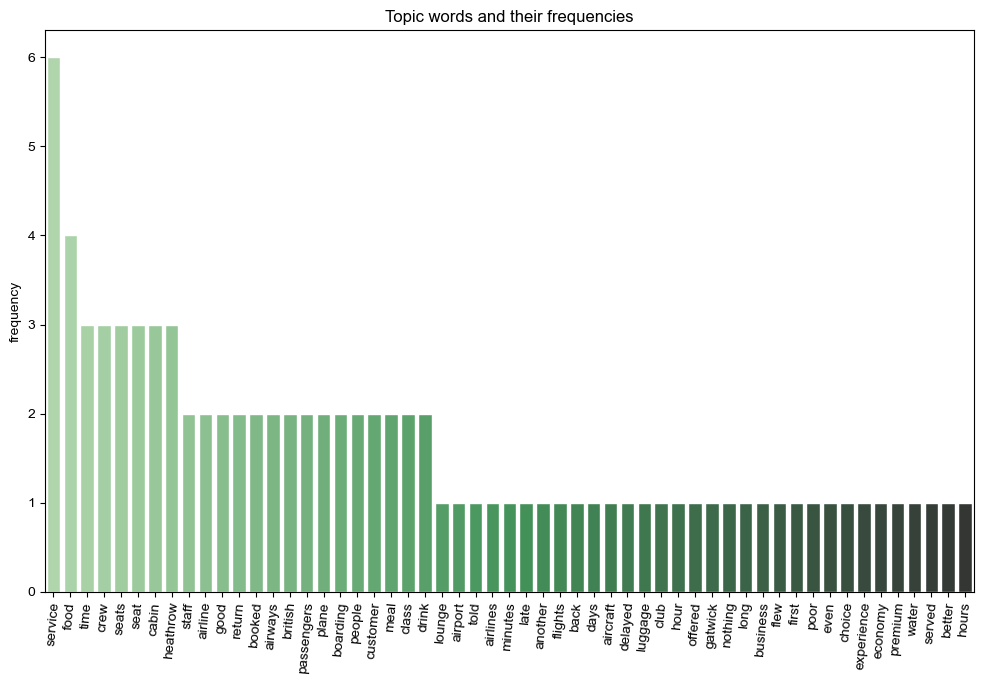

In [24]:
# create figure and axes
fig, ax = plt.subplots(figsize=(10,7), dpi=100)
sns.set(style="whitegrid", color_codes=True)
pal = sns.color_palette("Greens_d", len(df_topic_words))
sns.barplot(data=df_topic_words,x=df_topic_words.index,y='frequency',palette=pal)
plt.title('Topic words and their frequencies')
plt.xticks(rotation=85)
plt.tight_layout()

In [25]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Remove numbers and words with numbers
    filtered_tokens = [token for token in filtered_tokens if not any(c.isdigit() for c in token)]
    
    # Remove words with only one character
    filtered_tokens = [token for token in filtered_tokens if len(token) > 1]
    
    # Join filtered tokens into a string
    filtered_text = " ".join(filtered_tokens)
    
    return filtered_text

In [26]:
# Remove punctuation and convert to lowercase
text = neg_reviews["reviews"].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

# Remove numbers
text = text.apply(lambda x: re.sub(r'\d+', '', x))

# Remove extra whitespace
text = text.apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# Convert the text to a matrix of term frequency-inverse document frequency (TF-IDF) features, including 2-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(text)

# Build the Latent Dirichlet Allocation (LDA) model
lda = decomposition.LatentDirichletAllocation(n_components=10, random_state=42)

# Fit the model to the data
lda.fit(X)

# Print the top words for each topic
for i, topic in enumerate(lda.components_):
    print(f"Topic {i+1}:")
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])



Topic 1:


c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['we', 'flight', 'for', 'on', 'in', 'of', 'was', 'and', 'to', 'the']
Topic 2:
['fco', 'for better', 'foreign', 'the foreign', 'people to', 'floor', 'thing was', 'systems and', 'test', 'game']
Topic 3:
['across the', 'flights no', 'madeira', 'plane and', 'hours delay', 'stuttgart', 'couple of', 'alaska', 'with hours', 'go with']
Topic 4:
['per row', 'to warsaw', 'seats per', 'films and', 'and now', 'change of', 'per', 'though it', 'rio', 'highly']
Topic 5:
['have already', 'just cancel', 'was great', 'their website', 'surprised', 'great and', 'sat next', 'cello', 'areas', 'very friendly']
Topic 6:
['wt', 'pocket', 'my clubs', 'clubs', 'see why', 'ludicrous', 'rotterdam', 'price tag', 'frankly', 'canada']
Topic 7:
['abu dhabi', 'hamburg', 'not give', 'frequent flyer', 'back was', 'airways was', 'bucharest', 'to mauritius', 'worst of', 'not sure']
Topic 8:
['gone are', 'the offer', 'horrible food', 'on bags', 'york to', 'sad', 'gone downhill', 'mistake', 'have experienced', 'started with'

In [27]:
import gensim
from gensim.models import Word2Vec

In [28]:

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r"#(\w+)", " ", text)
    
    # Remove mentions
    text = re.sub(r"@\w+", " ", text)
    
    # Remove URLs
    text = re.sub(r"http\S+", " ", text)
    
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r"[^a-zA-Z0-9\s]+", " ", text)
    text = re.sub(r"\s+", " ", text)
    
    return text.strip()

text = preprocess_text(text)
reviews = [review.split() for review in text]

AttributeError: 'Series' object has no attribute 'lower'

In [ ]:
# # Remove punctuation and convert to lowercase
# text = neg_reviews["reviews"].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

# # Remove numbers
# text = text.apply(lambda x: re.sub(r'\d+', '', x))

# # Remove extra whitespace
# text = text.apply(lambda x: re.sub(r'\s+', ' ', x).strip())




# Train a word2vec model on the reviews
model = Word2Vec(reviews, vector_size =100, window=5, min_count=1, workers=4)


# Get the word vectors for each review
review_vectors = []
for review in reviews:
    review_vectors.append(np.mean([model.wv[word] for word in review], axis=0))

# Use k-means clustering to cluster the review vectors into 10 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(review_vectors)

# Print the top words for each cluster
for i in range(10):
    cluster_reviews = [reviews[j] for j in range(len(reviews)) if kmeans.labels_[j] == i]
    words = [word for review in cluster_reviews for word in review]
    word_counts = {}
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    print(f"Topic {i+1}:")
    print([x[0] for x in sorted_word_counts[:10]])

AttributeError: 'Series' object has no attribute 'lower'

### NER

In [ ]:
# !python -m spacy download en_core_web_sm --user



In [ ]:
import spacy

# Load pre-trained NER model
nlp = spacy.load("en_core_web_sm")


reviews = [review.split() for review in text]

# Apply NER on each review
ner_reviews = []
for review in reviews:
    # Join review tokens into a string
    review_str = " ".join(review)
    
    # Apply NER on review string
    doc = nlp(review_str)
    
    # Extract named entities and their labels
    ner_review = [(ent.text, ent.label_) for ent in doc.ents]
    
    # Add NER review to list
    ner_reviews.append(ner_review)
    



c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\adity\.conda\en

In [ ]:
from transformers import pipeline

# Load NER pipeline
ner_pipeline = pipeline("ner", model="bert-base-cased", tokenizer="bert-base-cased")


reviews = [review.split() for review in text]

# Apply NER on each review
ner_reviews = []
for review in reviews:
    # Join review tokens into a string
    review_str = " ".join(review)
    
    # Apply NER on review string
    ner_review = ner_pipeline(review_str)
    
    # Add NER review to list
    ner_reviews.append(ner_review)
    



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
ner_reviews[:3]

[[{'entity': 'LABEL_1',
   'score': 0.6470831,
   'index': 1,
   'word': 'b',
   'start': 0,
   'end': 1},
  {'entity': 'LABEL_1',
   'score': 0.5548681,
   'index': 2,
   'word': '##a',
   'start': 1,
   'end': 2},
  {'entity': 'LABEL_0',
   'score': 0.60296535,
   'index': 3,
   'word': 'cancelled',
   'start': 3,
   'end': 12},
  {'entity': 'LABEL_1',
   'score': 0.5753394,
   'index': 4,
   'word': 'my',
   'start': 13,
   'end': 15},
  {'entity': 'LABEL_0',
   'score': 0.5562099,
   'index': 5,
   'word': 'flight',
   'start': 16,
   'end': 22},
  {'entity': 'LABEL_1',
   'score': 0.54533684,
   'index': 6,
   'word': 'home',
   'start': 23,
   'end': 27},
  {'entity': 'LABEL_0',
   'score': 0.5987644,
   'index': 7,
   'word': 'to',
   'start': 28,
   'end': 30},
  {'entity': 'LABEL_1',
   'score': 0.60565746,
   'index': 8,
   'word': 'heat',
   'start': 31,
   'end': 35},
  {'entity': 'LABEL_1',
   'score': 0.5827858,
   'index': 9,
   'word': '##hr',
   'start': 35,
   'end': 

In [ ]:
unique_labels = set()
for review in ner_reviews:
    for entity in review:
        unique_labels.add(entity['entity'])
        
print(unique_labels)


{'LABEL_0', 'LABEL_1'}


In [ ]:
import pandas as pd

# Define empty dictionary to store entities and words
entities_dict = {}

# Loop through each review and extract entities and words
for review in ner_reviews:
    for entity in review:
        entity_type = entity['entity']
        word = entity['word']
        if entity_type in entities_dict:
            entities_dict[entity_type].append(word)
        else:
            entities_dict[entity_type] = [word]

# Create pandas dataframe from dictionary
df = pd.DataFrame.from_dict(entities_dict, orient='index')
df.index.name = 'Entity'
df.columns.name = 'Word'

# Create crosstab
crosstab_df = pd.crosstab(df.index, df[df.columns[0]])

# Display crosstab
crosstab_df


,b,cancelled
row_0,,
LABEL_0,0,1
LABEL_1,1,0


In [ ]:
entities = []
words = []
for review in ner_reviews:
    for entity in review:
        entities.append(entity['entity'])
        words.append(entity['word'])
        
df = pd.DataFrame({'Entity': entities, 'Word': words})
ner_out=df.groupby(['Entity', 'Word']).size().reset_index(name='Count')


,Entity,Word,Count
0,LABEL_0,##a,1140
1,LABEL_0,##aa,1
2,LABEL_0,##ab,3
3,LABEL_0,##ability,1
4,LABEL_0,##able,40
...,...,...,...
11799,LABEL_1,yourself,1
11800,LABEL_1,z,18
11801,LABEL_1,zero,4
11802,LABEL_1,zone,4


In [ ]:
ner_out.head(50)

,Entity,Word,Count
0,LABEL_0,##a,1140
1,LABEL_0,##aa,1
2,LABEL_0,##ab,3
3,LABEL_0,##ability,1
4,LABEL_0,##able,40
5,LABEL_0,##ably,2
6,LABEL_0,##abulous,1
7,LABEL_0,##ac,17
8,LABEL_0,##ach,3
9,LABEL_0,##aco,2
